# Imports

In [1]:
import numpy as np
from matplotlib.patches import ConnectionPatch
from scipy.stats import mannwhitneyu

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR, 
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)
from khan_helpers.functions import reconstruct_trace

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def format_stats(stat, p, stat_name, df=None):
    stat_fmt = fr'${stat_name}$'
    if df is not None:
        stat_fmt = f'{stat_fmt}({df})'
    
    if stat // 1 == stat:
        stat_val = int(stat)
    else:
        stat_val = f'{stat:.3f}'.rstrip('.0')
    
    stat_fmt = f'{stat_fmt} = {stat_val}\n$p$'
    if p < 0.001:
        p_fmt = ' < 0.001'
    else:
        p_fmt = f' = {p:.3f}'
    
    return f'{stat_fmt}{p_fmt}'

<h1>
    Estimate knowledge for:
    <ul>
        <li>each held-out question using all others</li>
        <li>each lecture 1 question using all lecture 2 questions</li>
        <li>each lecture 2 question using all lecture 1 questions</li>
        <li>each lecture 1 question using all other lecture 1 questions</li>
        <li>each lecture 2 question using all other lecture 2 questions</li>
    </ul>
</h1>

In [3]:
exp = Experiment()

In [4]:
knowledge_estimates = {
    'heldout_question': {},
    'lec1_given_lec1': {},
    'lec2_given_lec2': {},
    'lec1_given_lec2': {},
    'lec2_given_lec1': {}
}

for quiz in range(1, 4):
    heldout_correct = []
    heldout_incorrect = []
    
    lec1_given_lec1_correct = []
    lec1_given_lec1_incorrect = []
    lec2_given_lec2_correct = []
    lec2_given_lec2_incorrect = []
    
    lec1_given_lec2_correct = []
    lec1_given_lec2_incorrect = []
    lec2_given_lec1_correct = []
    lec2_given_lec1_incorrect = []
    
    for p in exp.participants:
        # data for all questions given participant saw on given quiz
        quiz_data = p.get_data(quiz=quiz-1)
        
        # iteratively hold out one question, estimate knowledge based on
        # performance on all other questions
        for ix, heldout_question_data in enumerate(quiz_data.itertuples()):
            if heldout_question_data.qID == 38:
                continue
            
            heldin_questions_data = quiz_data.drop(index=heldout_question_data.Index)
            heldout_question = exp.question_vectors[heldout_question_data.qID - 1]
            heldin_questions = exp.question_vectors[heldin_questions_data['qID'] - 1]
            accuracy = heldin_questions_data['accuracy']
            knowledge_estimate = reconstruct_trace(heldout_question[None, :], 
                                                   heldin_questions, 
                                                   accuracy).item()
            if heldout_question_data.accuracy == 1:
                heldout_correct.append(knowledge_estimate)
            else:
                heldout_incorrect.append(knowledge_estimate)
                
        # subset of quiz questions about each lecture 
        lec1_question_data = quiz_data.query('lecture == 1').reset_index(drop=True)
        lec2_question_data = quiz_data.query('lecture == 2').reset_index(drop=True)
        # accuracy for quiz questions about each lecture
        lec1_questions_acc = lec1_question_data['accuracy']
        lec2_questions_acc = lec2_question_data['accuracy']
        # topic vectors for quiz questions about each lecture
        lec1_questions_vecs = exp.question_vectors[lec1_question_data['qID'] - 1]
        lec2_questions_vecs = exp.question_vectors[lec2_question_data['qID'] - 1]
        
        # estimate knowledge for each lecture-related question given 
        # performance on (A) all other questions about the same lecture, 
        # and (B) all questions about the opposite lecture
        for q_ix in range(5):
            # quiz questions for which to estimate knowledge 
            lec1_target_question = lec1_questions_vecs[None, q_ix]
            lec2_target_question = lec2_questions_vecs[None, q_ix]
            # accuracy on target quiz questions
            lec1_target_question_acc = lec1_questions_acc[q_ix]
            lec2_target_question_acc = lec2_questions_acc[q_ix]
            # non-target quiz questions for within-lecture analysis (A)
            lec1_heldin_questions = np.delete(lec1_questions_vecs, q_ix, axis=0)
            lec2_heldin_questions = np.delete(lec2_questions_vecs, q_ix, axis=0)
            # accuracy on non-target quiz questions (for analysis A)
            lec1_heldin_questions_acc = lec1_questions_acc.drop(q_ix)
            lec2_heldin_questions_acc = lec2_questions_acc.drop(q_ix)
            
            # knowledge estimtes based on (A) 
            lec1_within_knowledge_estimate = reconstruct_trace(
                lec1_target_question,
                lec1_heldin_questions,
                lec1_heldin_questions_acc
            ).item()
            lec2_within_knowledge_estimate = reconstruct_trace(
                lec2_target_question,
                lec2_heldin_questions,
                lec2_heldin_questions_acc
            ).item()
            # knowledge estimtes based on (B) 
            lec1_across_knowledge_estimate = reconstruct_trace(
                lec1_target_question,
                lec2_questions_vecs,
                lec2_questions_acc
            ).item()
            lec2_across_knowledge_estimate = reconstruct_trace(
                lec2_target_question,
                lec1_questions_vecs,
                lec1_questions_acc
            ).item()
            
            if lec1_target_question_acc == 1:
                lec1_given_lec1_correct.append(lec1_within_knowledge_estimate)
                lec1_given_lec2_correct.append(lec1_across_knowledge_estimate)
            else:
                lec1_given_lec1_incorrect.append(lec1_within_knowledge_estimate)
                lec1_given_lec2_incorrect.append(lec1_across_knowledge_estimate)
            if lec2_target_question_acc == 1:
                lec2_given_lec2_correct.append(lec2_within_knowledge_estimate)
                lec2_given_lec1_correct.append(lec2_across_knowledge_estimate)
            else:
                lec2_given_lec2_incorrect.append(lec2_within_knowledge_estimate)
                lec2_given_lec1_incorrect.append(lec2_across_knowledge_estimate)
                
    quiz_str = f'quiz{quiz}'
    knowledge_estimates['heldout_question'][quiz_str] = {
        'correct': heldout_correct, 
        'incorrect': heldout_incorrect
    }
    knowledge_estimates['lec1_given_lec1'][f'quiz{quiz}'] = {
        'correct': lec1_given_lec1_correct,
        'incorrect': lec1_given_lec1_incorrect
    }
    knowledge_estimates['lec2_given_lec2'][f'quiz{quiz}'] = {
        'correct': lec2_given_lec2_correct,
        'incorrect': lec2_given_lec2_incorrect
    }
    knowledge_estimates['lec1_given_lec2'][quiz_str] = {
        'correct': lec1_given_lec2_correct,
        'incorrect': lec1_given_lec2_incorrect
    }
    knowledge_estimates['lec2_given_lec1'][quiz_str] = {
        'correct': lec2_given_lec1_correct,
        'incorrect': lec2_given_lec1_incorrect
    }

# Construct and display figure

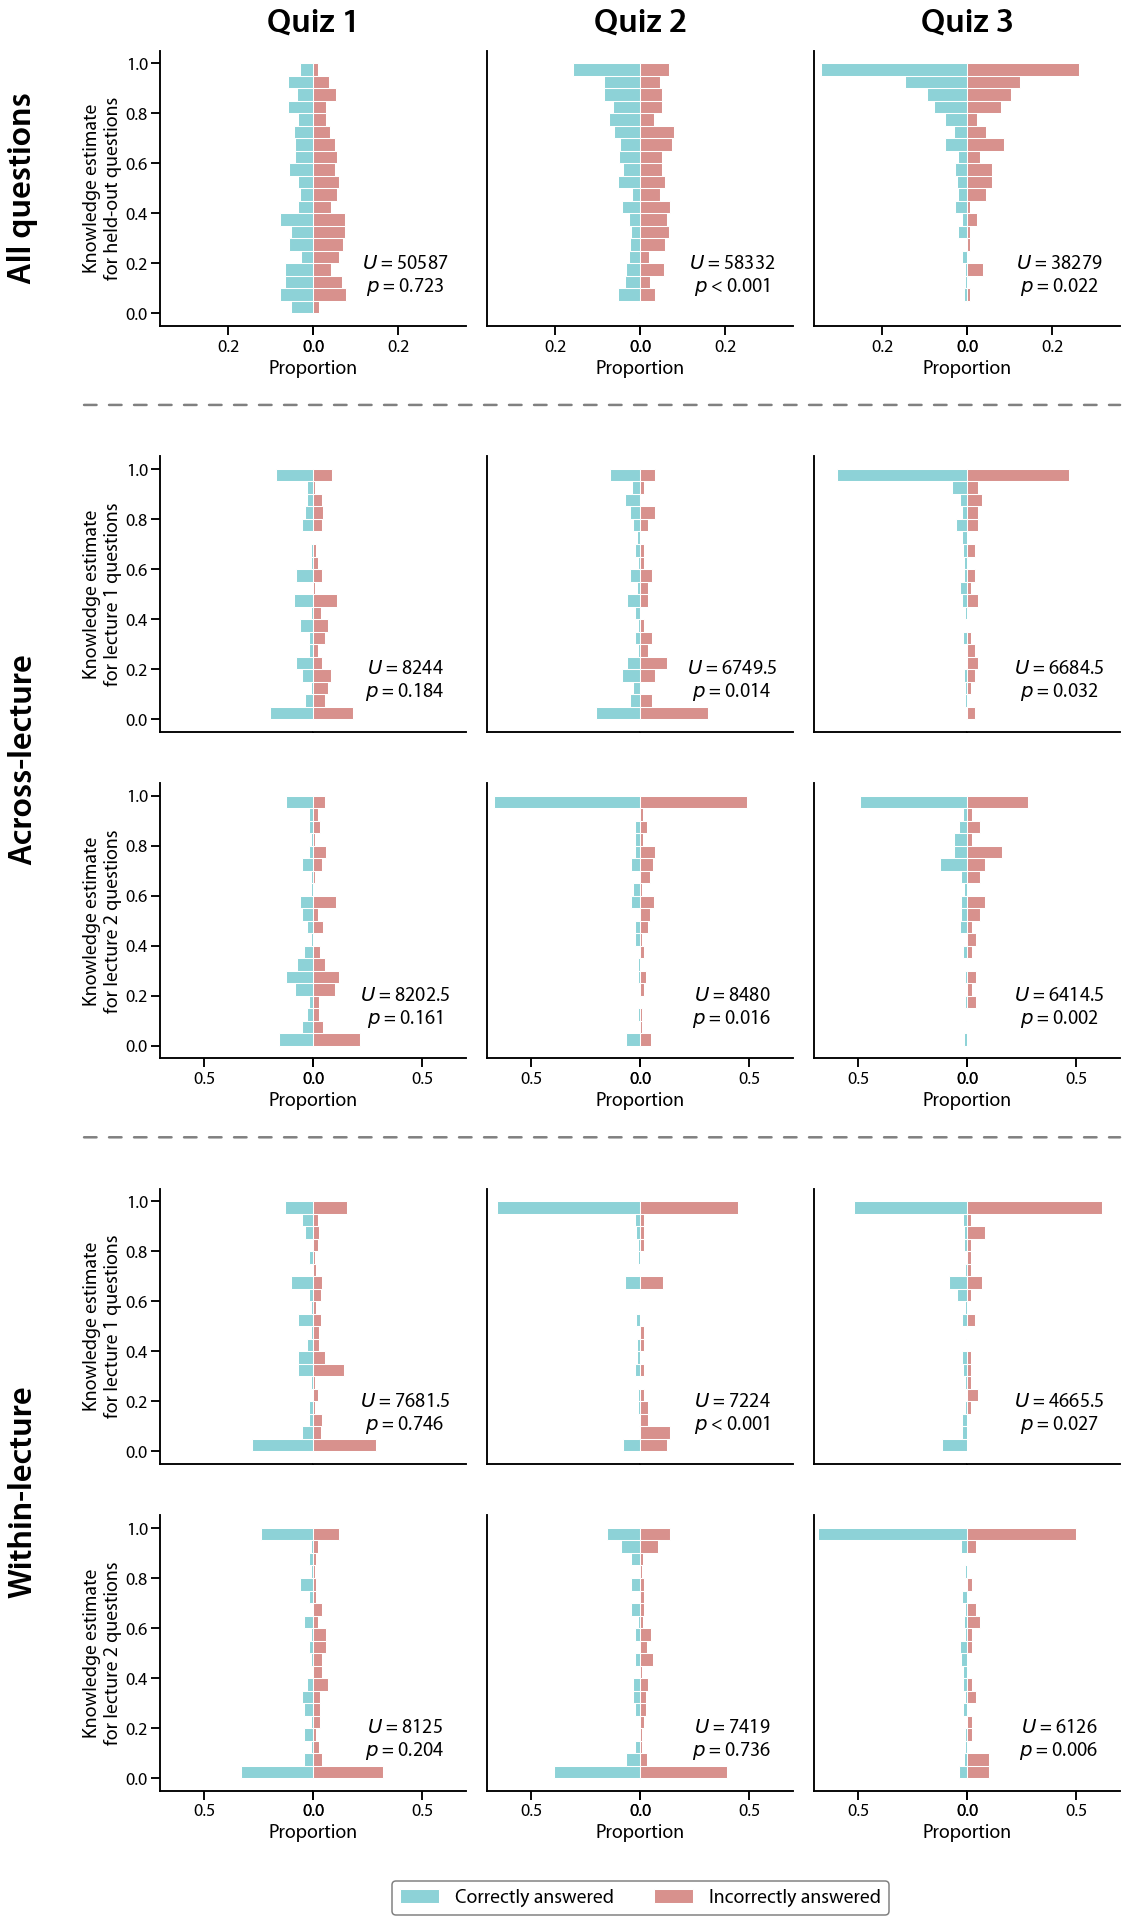

In [5]:
SEP_HEIGHT_RATIO = 0.1
LEGEND_HEIGHT_RATIO = 0.2
BINS = np.linspace(0, 1, 21, endpoint=True, dtype=np.float16)

with sns.plotting_context('talk', font_scale=1.1):
    fig = plt.figure(figsize=(15, 27), tight_layout={'h_pad': 0})
    main_gs = fig.add_gridspec(8, 3, height_ratios=(
        1, SEP_HEIGHT_RATIO, 1, 1, SEP_HEIGHT_RATIO, 1, 1, LEGEND_HEIGHT_RATIO
    ))

    # row 1: single held-out question
    quiz1_heldout_gs = main_gs[0].subgridspec(1, 2, wspace=0)
    quiz2_heldout_gs = main_gs[1].subgridspec(1, 2, wspace=0)
    quiz3_heldout_gs = main_gs[2].subgridspec(1, 2, wspace=0)
    
    # separator line 1
    sep1_ax1 = fig.add_subplot(main_gs[3])
    sep1_ax2 = fig.add_subplot(main_gs[5])
    
    # row 2: lecture 1 questions given lecture 2 questions
    quiz1_1_2_gs = main_gs[6].subgridspec(1, 2, wspace=0)
    quiz2_1_2_gs = main_gs[7].subgridspec(1, 2, wspace=0)
    quiz3_1_2_gs = main_gs[8].subgridspec(1, 2, wspace=0)

    # row 3: lecture 2 questions given lecture 1 questions
    quiz1_2_1_gs = main_gs[9].subgridspec(1, 2, wspace=0)
    quiz2_2_1_gs = main_gs[10].subgridspec(1, 2, wspace=0)
    quiz3_2_1_gs = main_gs[11].subgridspec(1, 2, wspace=0)
    
    # separator line 2
    sep2_ax1 = fig.add_subplot(main_gs[12])
    sep2_ax2 = fig.add_subplot(main_gs[14])
    
    # row 4: lecture 1 questions given lecture 1 questions
    quiz1_1_1_gs = main_gs[15].subgridspec(1, 2, wspace=0)
    quiz2_1_1_gs = main_gs[16].subgridspec(1, 2, wspace=0)
    quiz3_1_1_gs = main_gs[17].subgridspec(1, 2, wspace=0)

    # row 5: lecture 2 questions given lecture 2 questions
    quiz1_2_2_gs = main_gs[18].subgridspec(1, 2, wspace=0)
    quiz2_2_2_gs = main_gs[19].subgridspec(1, 2, wspace=0)
    quiz3_2_2_gs = main_gs[20].subgridspec(1, 2, wspace=0)
    
    # legend
    legend_ax = fig.add_subplot(main_gs[21:])
    
    # ==================================================================
    
    # row 1 panels paired sub-axes
    ax1 = fig.add_subplot(quiz1_heldout_gs[0])
    ax2 = fig.add_subplot(quiz1_heldout_gs[1], sharey=ax1)
    ax3 = fig.add_subplot(quiz2_heldout_gs[0], sharex=ax1, sharey=ax1)
    ax4 = fig.add_subplot(quiz2_heldout_gs[1], sharex=ax2, sharey=ax1)
    ax5 = fig.add_subplot(quiz3_heldout_gs[0], sharex=ax1, sharey=ax1)
    ax6 = fig.add_subplot(quiz3_heldout_gs[1], sharex=ax2, sharey=ax1)
    
    # row 2 panels paired sub-axes
    ax7 = fig.add_subplot(quiz1_1_2_gs[0], sharey=ax1)
    ax8 = fig.add_subplot(quiz1_1_2_gs[1], sharey=ax1)
    ax9 = fig.add_subplot(quiz2_1_2_gs[0], sharex=ax7, sharey=ax1)
    ax10 = fig.add_subplot(quiz2_1_2_gs[1], sharex=ax8, sharey=ax1)
    ax11 = fig.add_subplot(quiz3_1_2_gs[0], sharex=ax7, sharey=ax1)
    ax12 = fig.add_subplot(quiz3_1_2_gs[1], sharex=ax8, sharey=ax1)
    
    # row 3 panels paired sub-axes
    ax13 = fig.add_subplot(quiz1_2_1_gs[0], sharex=ax7, sharey=ax1)
    ax14 = fig.add_subplot(quiz1_2_1_gs[1], sharex=ax8, sharey=ax1)
    ax15 = fig.add_subplot(quiz2_2_1_gs[0], sharex=ax7, sharey=ax1)
    ax16 = fig.add_subplot(quiz2_2_1_gs[1], sharex=ax8, sharey=ax1)
    ax17 = fig.add_subplot(quiz3_2_1_gs[0], sharex=ax7, sharey=ax1)
    ax18 = fig.add_subplot(quiz3_2_1_gs[1], sharex=ax8, sharey=ax1)
    
    # row 4 panels paired sub-axes
    ax19 = fig.add_subplot(quiz1_1_1_gs[0], sharex=ax7, sharey=ax1)
    ax20 = fig.add_subplot(quiz1_1_1_gs[1], sharex=ax8, sharey=ax1)
    ax21 = fig.add_subplot(quiz2_1_1_gs[0], sharex=ax7, sharey=ax1)
    ax22 = fig.add_subplot(quiz2_1_1_gs[1], sharex=ax8, sharey=ax1)
    ax23 = fig.add_subplot(quiz3_1_1_gs[0], sharex=ax7, sharey=ax1)
    ax24 = fig.add_subplot(quiz3_1_1_gs[1], sharex=ax8, sharey=ax1)
    
    # row 5 panels paired sub-axes
    ax25 = fig.add_subplot(quiz1_2_2_gs[0], sharex=ax7, sharey=ax1)
    ax26 = fig.add_subplot(quiz1_2_2_gs[1], sharex=ax8, sharey=ax1)
    ax27 = fig.add_subplot(quiz2_2_2_gs[0], sharex=ax7, sharey=ax1)
    ax28 = fig.add_subplot(quiz2_2_2_gs[1], sharex=ax8, sharey=ax1)
    ax29 = fig.add_subplot(quiz3_2_2_gs[0], sharex=ax7, sharey=ax1)
    ax30 = fig.add_subplot(quiz3_2_2_gs[1], sharex=ax8, sharey=ax1)
    
    axarr_row1 = np.array((ax1, ax2, ax3, ax4, ax5, ax6))
    axarr_row2 = np.array((ax7, ax8, ax9, ax10, ax11, ax12))
    axarr_row3 = np.array((ax13, ax14, ax15, ax16, ax17, ax18))
    axarr_row4 = np.array((ax19, ax20, ax21, ax22, ax23, ax24))
    axarr_row5 = np.array((ax25, ax26, ax27, ax28, ax29, ax30))
    
    axarr_rows = (axarr_row1, axarr_row2, axarr_row3, axarr_row4, axarr_row5)
    knowledge_estimate_rows = ('heldout_question', 
                               'lec1_given_lec2', 
                               'lec2_given_lec1', 
                               'lec1_given_lec1', 
                               'lec2_given_lec2')
    
    sns.despine(top=True, right=True, left=False, bottom=False)
    
    # ==================================================================
    
    # create paired distribution plots
    for i, axarr in enumerate(axarr_rows):
        row_knowledge_estimates = knowledge_estimates[knowledge_estimate_rows[i]]

        for quiz, (left_subax, right_subax) in enumerate(axarr.reshape(3, 2), 
                                                         start=1):
            quiz_estimates = row_knowledge_estimates[f'quiz{quiz}']
            correct_estimates = quiz_estimates['correct']
            incorrect_estimates = quiz_estimates['incorrect']

            # left sub-axis (correctly answered questions)
            sns.histplot(y=correct_estimates, 
                         bins=BINS,
                         stat='proportion',
                         color=CORRECT_ANSWER_COLOR,
                         edgecolor='white',
                         ax=left_subax, 
                         label='correct')
            left_subax.set_xlabel(None)
            left_subax.spines['right'].set_visible(False)
            
            # right sub-axis (incorrectly answered questions)
            sns.histplot(y=incorrect_estimates, 
                         bins=BINS,
                         stat='proportion',
                         color=INCORRECT_ANSWER_COLOR,
                         edgecolor='white',
                         ax=right_subax, 
                         label='incorrect')
            right_subax.set_xlabel(None)
            right_subax.spines['left'].set_visible(False)
            
            # stats annotation
            U, p = mannwhitneyu(correct_estimates, incorrect_estimates)
            right_subax.annotate(format_stats(U, p, 'U'), 
                                 xy=(0.6, 0.125),
                                 xycoords='axes fraction',
                                 fontsize='medium',
                                 ha='center')
            
        for ax in axarr[1:]:
            ax.tick_params(left=False, labelleft=False)
            
    # ==================================================================
    
    # add separator lines
    sepline1 = ConnectionPatch(xyA=(-0.25, 0), 
                               xyB=(1, 0), 
                               coordsA='axes fraction', 
                               coordsB='axes fraction',
                               axesA=sep1_ax1,
                               axesB=sep1_ax2,
                               linestyle=(0, (5, 5)),
                               linewidth=2.5,
                               color='grey')
    sepline2 = ConnectionPatch(xyA=(-0.25, 0), 
                               xyB=(1, 0), 
                               coordsA='axes fraction', 
                               coordsB='axes fraction',
                               axesA=sep2_ax1,
                               axesB=sep2_ax2,
                               linestyle=(0, (5, 5)),
                               linewidth=2.5,
                               color='grey')
    fig.add_artist(sepline1)
    fig.add_artist(sepline2)
    sep1_ax1.axis('off')
    sep1_ax2.axis('off')
    sep2_ax1.axis('off')
    sep2_ax2.axis('off')
    
    # ==================================================================
    
    # format axes, add labels
    ax1.set_xlim(0, 0.36)
    ax2.set_xlim(0, 0.36)
    ax1.invert_xaxis()
    
    ax7.set_xlim(0, 0.7)
    ax8.set_xlim(0, 0.7)
    ax7.invert_xaxis()
    
    ax1.set_ylim(-0.05, 1.05)
    
    for i in range(6):
        axarr_row2[i].xaxis.set_visible(False)
        axarr_row2[i].tick_params(bottom=False, labelbottom=False)
        axarr_row4[i].xaxis.set_visible(False)
        axarr_row4[i].tick_params(bottom=False, labelbottom=False)
        if not i % 2:
            axarr_row1[i].set_title(f'Quiz {i // 2 + 1}', 
                                   x=1,
                                   y=1.05, 
                                   fontsize='xx-large', 
                                   fontweight='semibold')
            axarr_row1[i].set_xlabel('Proportion', x=1, ha='center')
            axarr_row3[i].set_xlabel('Proportion', x=1, ha='center')
            axarr_row5[i].set_xlabel('Proportion', x=1, ha='center')
            
    ax1.set_ylabel('Knowledge estimate\nfor held-out questions')
    ax7.set_ylabel('Knowledge estimate\nfor lecture 1 questions')
    ax13.set_ylabel('Knowledge estimate\nfor lecture 2 questions')
    ax19.set_ylabel('Knowledge estimate\nfor lecture 1 questions')
    ax25.set_ylabel('Knowledge estimate\nfor lecture 2 questions')
    fig.text(x=-0.8,
             y=0.5,
             s='All questions',
             fontsize='xx-large',
             fontweight='semibold',
             rotation=90,
             ha='right',
             va='center',
             transform=ax1.transAxes)
    fig.text(x=-0.8,
             y=-0.1,
             s='Across-lecture',
             fontsize='xx-large',
             fontweight='semibold',
             rotation=90,
             ha='right',
             va='center', 
             transform=ax7.transAxes)
    fig.text(x=-0.8,
             y=-0.1,
             s='Within-lecture',
             fontsize='xx-large',
             fontweight='semibold',
             rotation=90,
             ha='right',
             va='center', 
             transform=ax19.transAxes)
    
    # ==================================================================
    
    # add shared legend
    legend = legend_ax.legend((ax1.containers[0], ax2.containers[0]), 
                              ('Correctly answered', 'Incorrectly answered'), 
                              loc='lower center', 
                              ncol=2, 
                              fontsize='medium',
                              edgecolor='grey',
                              framealpha=1, 
                              bbox_to_anchor=(0.5, -0.5))
    legend_ax.axis('off')
        
#     plt.savefig(FIG_DIR.joinpath('predict-knowledge-questions-expanded.pdf'), 
#                 bbox_inches='tight', 
#                 dpi=300)
    plt.show()